# Figure 3 MPP

Run with this command in docker container

docker run \
--rm \
-d \
--name scanpy2 \
-p 8880:8888 \
-e JUPYTER_ENABLE_LAB=YES \
-v /Users/efast/Documents/:/home/jovyan/work \
scanpy:1.4.6

## 1) Loading packages + data

In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from gprofiler import GProfiler
import seaborn as sns; sns.set() 
from helper_functions import *

from upsetplot import UpSet
import re

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)

In [3]:
sc.settings.set_figure_params(dpi=80, dpi_save=300, vector_friendly=True)

In [4]:
adata = sc.read(
    './sc_objects/MPP_preprocessed.h5ad')

In [5]:
adata.var_names_make_unique()

In [6]:
adata

AnnData object with n_obs × n_vars = 8191 × 13827 
    obs: 'assignment', 'batch', 'counts', 'demux_type', 'hto_type', 'rna_type', 'sample', 'select_cells', 'n_counts', 'log_counts', 'n_genes', 'percent_mito', 'Female', 'Female_cat', 'Female_str', 'sex_sample', 'rXist', 'leiden', 'umap_density_sample', 'umap_density_assignment'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'assignment_colors', 'diffmap_evals', 'draw_graph', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'sample_colors', 'sex_sample_colors', 'umap', 'umap_density_assignment_params', 'umap_density_sample_params'
    obsm: 'X_diffmap', 'X_draw_graph_fr', 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'

## Check the previous clustering

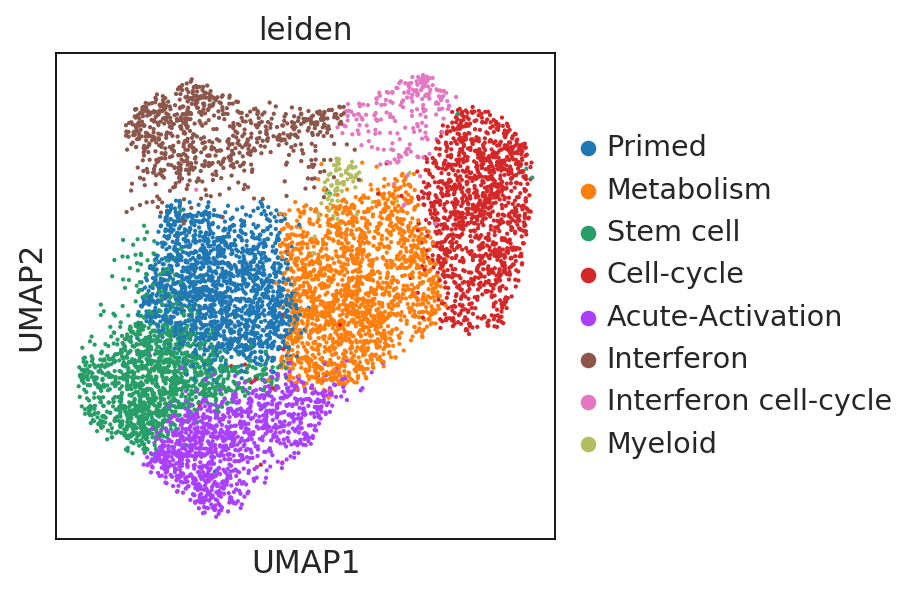

In [7]:
# rename cluster categories
adata.rename_categories('leiden', ['Primed', 'Metabolism', 'Stem cell', 'Cell-cycle', 'Acute-Activation', 
                                   'Interferon', 'Interferon cell-cycle','Myeloid'])
sc.pl.umap(adata, color='leiden')

## Look which signatures are enriched in the different clusters

In [8]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:19)


In [9]:
# which genes are enriched in which groups
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
enrichment_clusters = pd.DataFrame({group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'scores']})
#.head(5)

pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(10)

,Primed,Metabolism,Stem cell,Cell-cycle,Acute-Activation,Interferon,Interferon cell-cycle,Myeloid
0,Rps9,Dut,Ftl1,Hmgb2,Ctla2a,Serpina3g,Cxcl10,Tmsb4x
1,Rpl18a,Lig1,Ifitm1,Ube2c,Ifngr1,Cxcl10,Parp14,Tyrobp
2,Rpl10,Tyms,Jund,Cdca8,Tsc22d3,Rsad2,Irf1,Ap3s1
3,Rpl32,Ppia,Hlf,Nusap1,Plaur,Iigp1,Gbp5,Taldo1
4,Ogt,Ran,Malat1,Ccnb2,Cebpb,Serpina3f,Iigp1,Lgals1
5,Rps18,Ranbp1,Rps14,Cenpf,Neurl3,Ifit1,Cd69,Tspo
6,Rpl17,Dctpp1,Rpl21,Cks2,Gm10076,Isg15,Usp18,Fcer1g
7,Rps11,Ybx1,Fos,Birc5,Cytip,Igtp,Gbp7,Clec12a
8,Rps14,Gmnn,Cd63,Mki67,Pde4b,Gbp5,Igtp,Ctsg
9,Rpl18,Uhrf1,Ier2,Tubb4b,Stk17b,Ifi203,Isg15,Rab44


In [10]:
# make new column in adata.obs for cluster sample
adata.obs['cluster_sample'] = adata.obs['sample'].str.cat(others = adata.obs['leiden'], sep='_')
adata.obs['cluster_sample']=adata.obs['cluster_sample'].astype('category', copy=True) # make a column with category as dtype

# make new column in adata.obs for cluster MPP type
adata.obs['cluster_assignment'] = adata.obs['assignment'].str.cat(others = adata.obs['leiden'], sep='_')
adata.obs['cluster_assignment']=adata.obs['cluster_assignment'].astype('category', copy=True) # make a column with category as dtype

In [11]:
adata.obs.head()

,assignment,batch,counts,demux_type,hto_type,rna_type,sample,select_cells,n_counts,log_counts,...,Female,Female_cat,Female_str,sex_sample,rXist,leiden,umap_density_sample,umap_density_assignment,cluster_sample,cluster_assignment
AAACGAAGTTGGACCC-0,MPP3/4,batch1,902.0,singlet,background,signal,ct,1.0,13508.0,9.511259,...,True,True,true,ct_true,3.158928,Metabolism,0.637315,0.847134,ct_Metabolism,MPP3/4_Metabolism
AAAGGATCACGCTGAC-0,MPP,batch1,869.0,singlet,background,signal,ct,1.0,18172.0,9.807637,...,True,True,true,ct_true,3.078445,Primed,0.783623,0.335968,ct_Primed,MPP_Primed
AAAGGATGTAGTCTGT-0,MPP3/4,batch1,694.0,singlet,background,signal,ct,1.0,8688.0,9.070044,...,True,True,true,ct_true,3.206680,Primed,0.866588,0.514442,ct_Primed,MPP3/4_Primed
AAAGGGCAGCAGCGAT-0,MPP,batch1,848.0,singlet,background,signal,ct,1.0,8510.0,9.049468,...,False,False,false,ct_false,-0.049406,Primed,0.675819,0.257006,ct_Primed,MPP_Primed
AAAGGTATCTTCGACC-0,MPP3/4,batch1,3446.0,singlet,signal,signal,ct,1.0,15875.0,9.672815,...,True,True,true,ct_true,2.978796,Cell-cycle,0.668953,0.709803,ct_Cell-cycle,MPP3/4_Cell-cycle


In [12]:
adata.obs['cluster_sample'].cat.categories.tolist()

['GCSF_Acute-Activation',
 'GCSF_Cell-cycle',
 'GCSF_Interferon',
 'GCSF_Interferon cell-cycle',
 'GCSF_Metabolism',
 'GCSF_Myeloid',
 'GCSF_Primed',
 'GCSF_Stem cell',
 'ct_Acute-Activation',
 'ct_Cell-cycle',
 'ct_Interferon',
 'ct_Metabolism',
 'ct_Myeloid',
 'ct_Primed',
 'ct_Stem cell',
 'dmPGE2_Acute-Activation',
 'dmPGE2_Cell-cycle',
 'dmPGE2_Interferon',
 'dmPGE2_Metabolism',
 'dmPGE2_Myeloid',
 'dmPGE2_Primed',
 'dmPGE2_Stem cell',
 'indo_Acute-Activation',
 'indo_Cell-cycle',
 'indo_Interferon',
 'indo_Interferon cell-cycle',
 'indo_Metabolism',
 'indo_Myeloid',
 'indo_Primed',
 'indo_Stem cell',
 'pIC_Cell-cycle',
 'pIC_Interferon',
 'pIC_Interferon cell-cycle',
 'pIC_Metabolism',
 'pIC_Myeloid',
 'pIC_Primed',
 'pIC_Stem cell']

In [13]:
# Order of the lineage
lin = ('GCSF_Acute-Activation',
 'GCSF_Cell-cycle',
 'GCSF_Interferon',
 'GCSF_Interferon cell-cycle',
 'GCSF_Metabolism',
 'GCSF_Myeloid',
 'GCSF_Primed',
 'GCSF_Stem cell',
 'ct_Acute-Activation',
 'ct_Cell-cycle',
 'ct_Interferon',
 'ct_Metabolism',
 'ct_Myeloid',
 'ct_Primed',
 'ct_Stem cell',
 'dmPGE2_Acute-Activation',
 'dmPGE2_Cell-cycle',
 'dmPGE2_Interferon',
 'dmPGE2_Metabolism',
 'dmPGE2_Myeloid',
 'dmPGE2_Primed',
 'dmPGE2_Stem cell',
 'indo_Acute-Activation',
 'indo_Cell-cycle',
 'indo_Interferon',
 'indo_Interferon cell-cycle',
 'indo_Metabolism',
 'indo_Myeloid',
 'indo_Primed',
 'indo_Stem cell',
 'pIC_Cell-cycle',
 'pIC_Interferon',
 'pIC_Interferon cell-cycle',
 'pIC_Metabolism',
 'pIC_Myeloid',
 'pIC_Primed',
 'pIC_Stem cell')


# Reordering leiden labels using Categorical data type
adata.obs['cluster_sample'] = adata.obs['cluster_sample'].cat.reorder_categories((lin), ordered=True)

In [14]:
receptors = ['Tlr3', 'Ifnar2', 'Ifnar1', 'Ifngr1', 'Ifngr2', 'Csf3r', 'Ptger2', 'Ptger3', 'Ptger4']
color = ['#884EA0', '#884EA0', '#884EA0', '#884EA0', '#884EA0', '#28B463', '#EC7063', '#EC7063', '#EC7063']

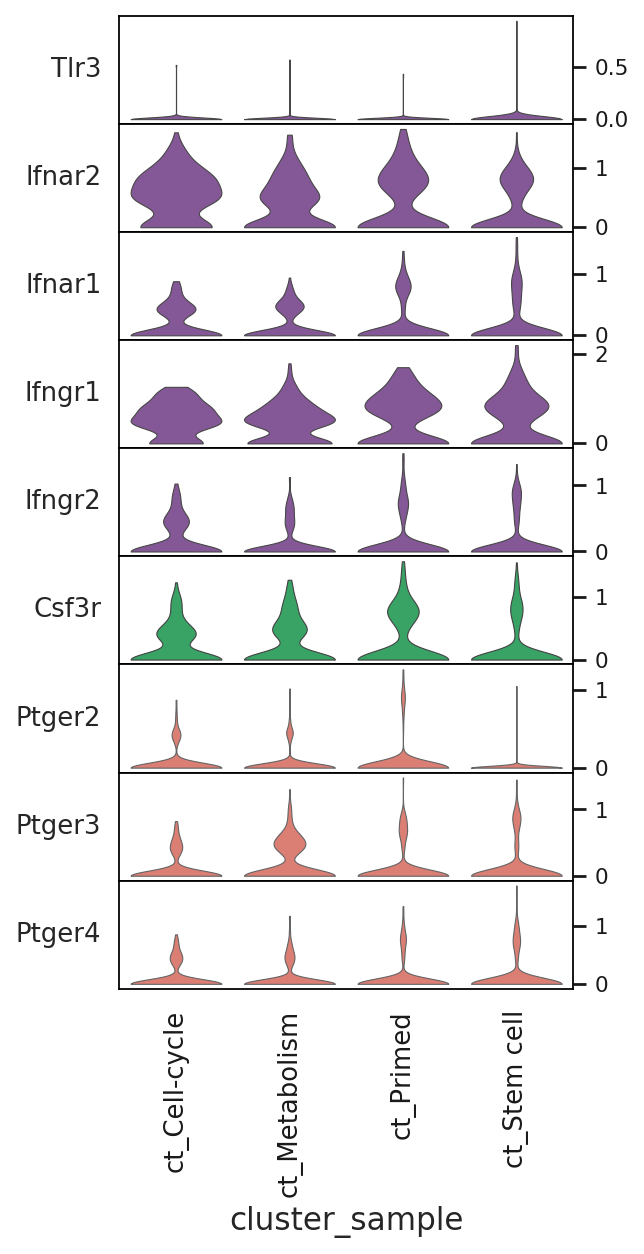

In [15]:
sc.pl.stacked_violin(adata[(adata.obs['cluster_sample']=='ct_Stem cell') |
                           (adata.obs['cluster_sample']=='ct_Primed') |
                           (adata.obs['cluster_sample']=='ct_Metabolism') |
                           (adata.obs['cluster_sample']=='ct_Cell-cycle') 
                           ],
                         receptors, figsize=(4,8), log=False, swap_axes=True, groupby='cluster_sample', 
                         color = color, save='_MPP_receptors_ct.pdf')

In [16]:
adata.obs['cluster_assignment'].cat.categories.tolist()

['LT_Cell-cycle',
 'LT_Interferon',
 'LT_Metabolism',
 'LT_Stem cell',
 'MPP1_Acute-Activation',
 'MPP1_Cell-cycle',
 'MPP1_Interferon',
 'MPP1_Interferon cell-cycle',
 'MPP1_Metabolism',
 'MPP1_Primed',
 'MPP1_Stem cell',
 'MPP2_Acute-Activation',
 'MPP2_Cell-cycle',
 'MPP2_Interferon',
 'MPP2_Interferon cell-cycle',
 'MPP2_Metabolism',
 'MPP2_Myeloid',
 'MPP2_Primed',
 'MPP2_Stem cell',
 'MPP3/4_Acute-Activation',
 'MPP3/4_Cell-cycle',
 'MPP3/4_Interferon',
 'MPP3/4_Interferon cell-cycle',
 'MPP3/4_Metabolism',
 'MPP3/4_Myeloid',
 'MPP3/4_Primed',
 'MPP3/4_Stem cell',
 'MPP_Acute-Activation',
 'MPP_Cell-cycle',
 'MPP_Interferon',
 'MPP_Interferon cell-cycle',
 'MPP_Metabolism',
 'MPP_Myeloid',
 'MPP_Primed',
 'MPP_Stem cell']

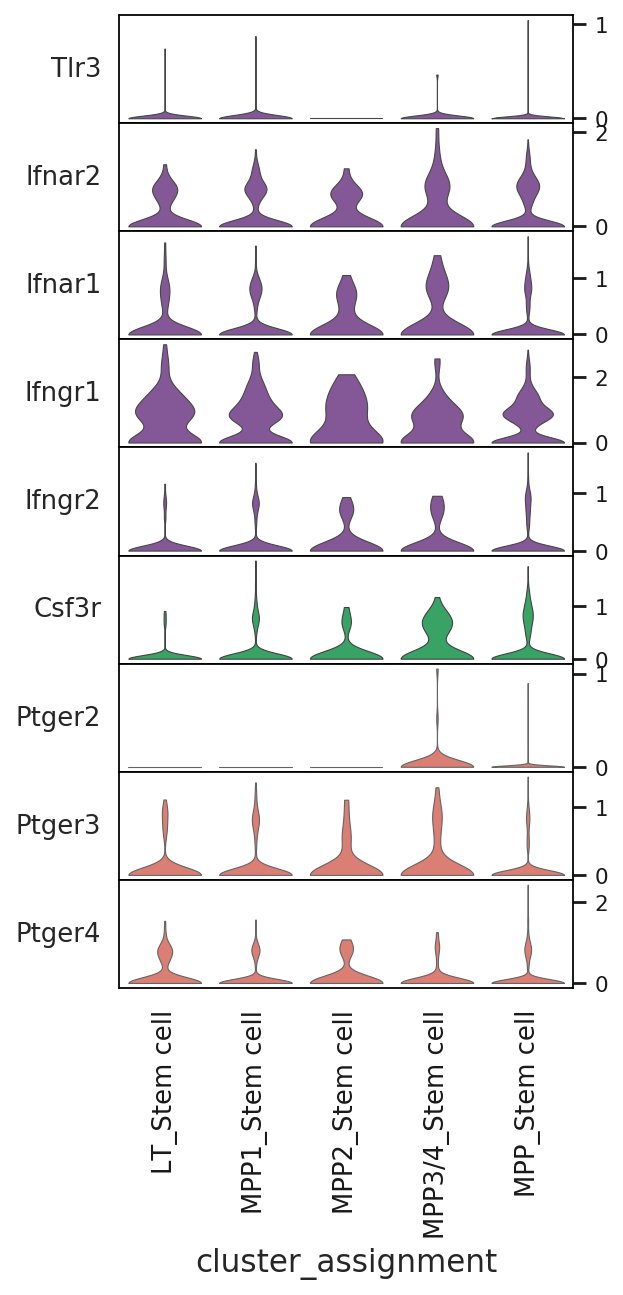

In [17]:
sc.pl.stacked_violin(adata[(adata.obs['cluster_assignment']=='MPP_Stem cell') |
                           (adata.obs['cluster_assignment']=='MPP1_Stem cell') |
                           (adata.obs['cluster_assignment']=='LT_Stem cell') |
                           (adata.obs['cluster_assignment']=='MPP2_Stem cell') |
                           (adata.obs['cluster_assignment']=='MPP3/4_Stem cell') 
                           ],
                         receptors, figsize=(4,8), log=False, swap_axes=True, groupby='cluster_assignment', 
                         color = color, save='_MPP_receptors_stem_cell.pdf')



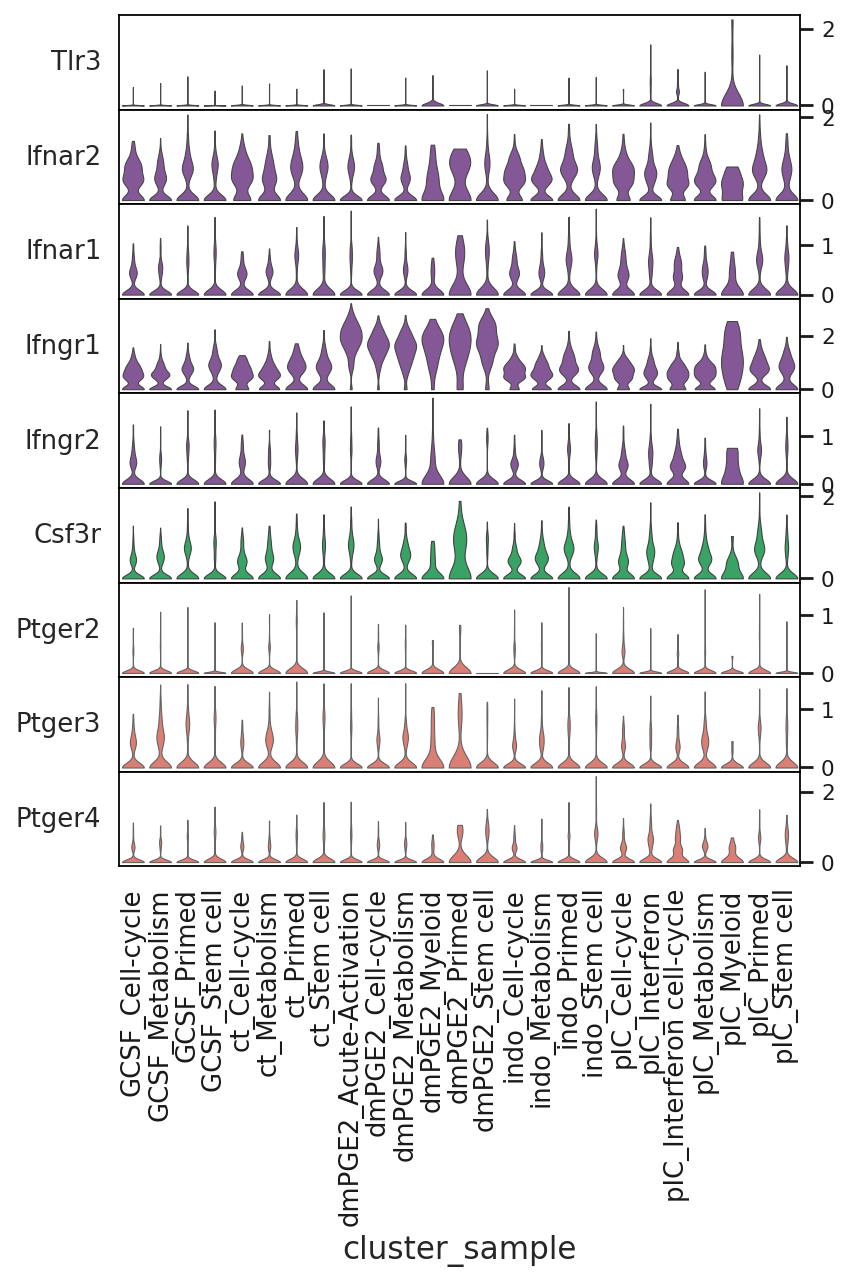

In [18]:
sc.pl.stacked_violin(adata[(adata.obs['cluster_sample']=='ct_Stem cell') |
                           (adata.obs['cluster_sample']=='ct_Primed') |
                           (adata.obs['cluster_sample']=='ct_Metabolism') |
                           (adata.obs['cluster_sample']=='ct_Cell-cycle') |
                           
                           (adata.obs['cluster_sample']=='pIC_Stem cell') |
                           (adata.obs['cluster_sample']=='pIC_Primed') |
                           (adata.obs['cluster_sample']=='pIC_Metabolism') |
                           (adata.obs['cluster_sample']=='pIC_Cell-cycle') |
                           (adata.obs['cluster_sample']=='pIC_Interferon') |
                           (adata.obs['cluster_sample']=='pIC_Interferon cell-cycle') |
                           (adata.obs['cluster_sample']=='pIC_Myeloid') |

                           (adata.obs['cluster_sample']=='dmPGE2_Stem cell') |
                           (adata.obs['cluster_sample']=='dmPGE2_Primed') |
                           (adata.obs['cluster_sample']=='dmPGE2_Metabolism') |
                           (adata.obs['cluster_sample']=='dmPGE2_Cell-cycle') |
                           (adata.obs['cluster_sample']=='dmPGE2_Acute-Activation') |
                           (adata.obs['cluster_sample']=='dmPGE2_Myeloid') |

                           (adata.obs['cluster_sample']=='GCSF_Stem cell') |
                           (adata.obs['cluster_sample']=='GCSF_Primed') |
                           (adata.obs['cluster_sample']=='GCSF_Metabolism') |
                           (adata.obs['cluster_sample']=='GCSF_Cell-cycle') |
                           
                           (adata.obs['cluster_sample']=='indo_Stem cell') |
                           (adata.obs['cluster_sample']=='indo_Primed') |
                           (adata.obs['cluster_sample']=='indo_Metabolism') |
                           (adata.obs['cluster_sample']=='indo_Cell-cycle')            
                      ],
                     receptors, figsize=(6,7), log=False, swap_axes=True, groupby='cluster_sample', 
                     color = color, save='_MPP_receptors_all_groups.pdf')

In [19]:
lin_tf = {'HSC': ['Runx1', 'Tal1','Lmo2', 'Bmi1', 'Gfi1', 'Gata2'],
                'Erythroid': ['Klf1', 'Gata1'],
              'Mega': ['Fli1', 'Nfe2',  'Gata1'],
              'Myeloid': ['Cebpa', 'Cebpa','Spi1', 'Gfi1'],
              'T-cell': [ 'Gata3', 'Runx3', 'Batf', 'Notch1', 'Zbtb7b', 'Tcf3', 'Ikzf1', 'Spi1',],
              'B-cell': ['Zbtb7a', 'Ebf1', 'Bcl11a', 'Xbp1', 'Irf4',],
              }
# len review with stu orkin https://www.sciencedirect.com/science/article/pii/S0092867408001256#fig1
# this is also good for lineage markers https://www.sciencedirect.com/science/article/pii/S1934590907002202#mmc3

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden']`
categories: Primed, Metabolism, Stem cell, etc.
var_group_labels: HSC, Erythroid, Mega, etc.


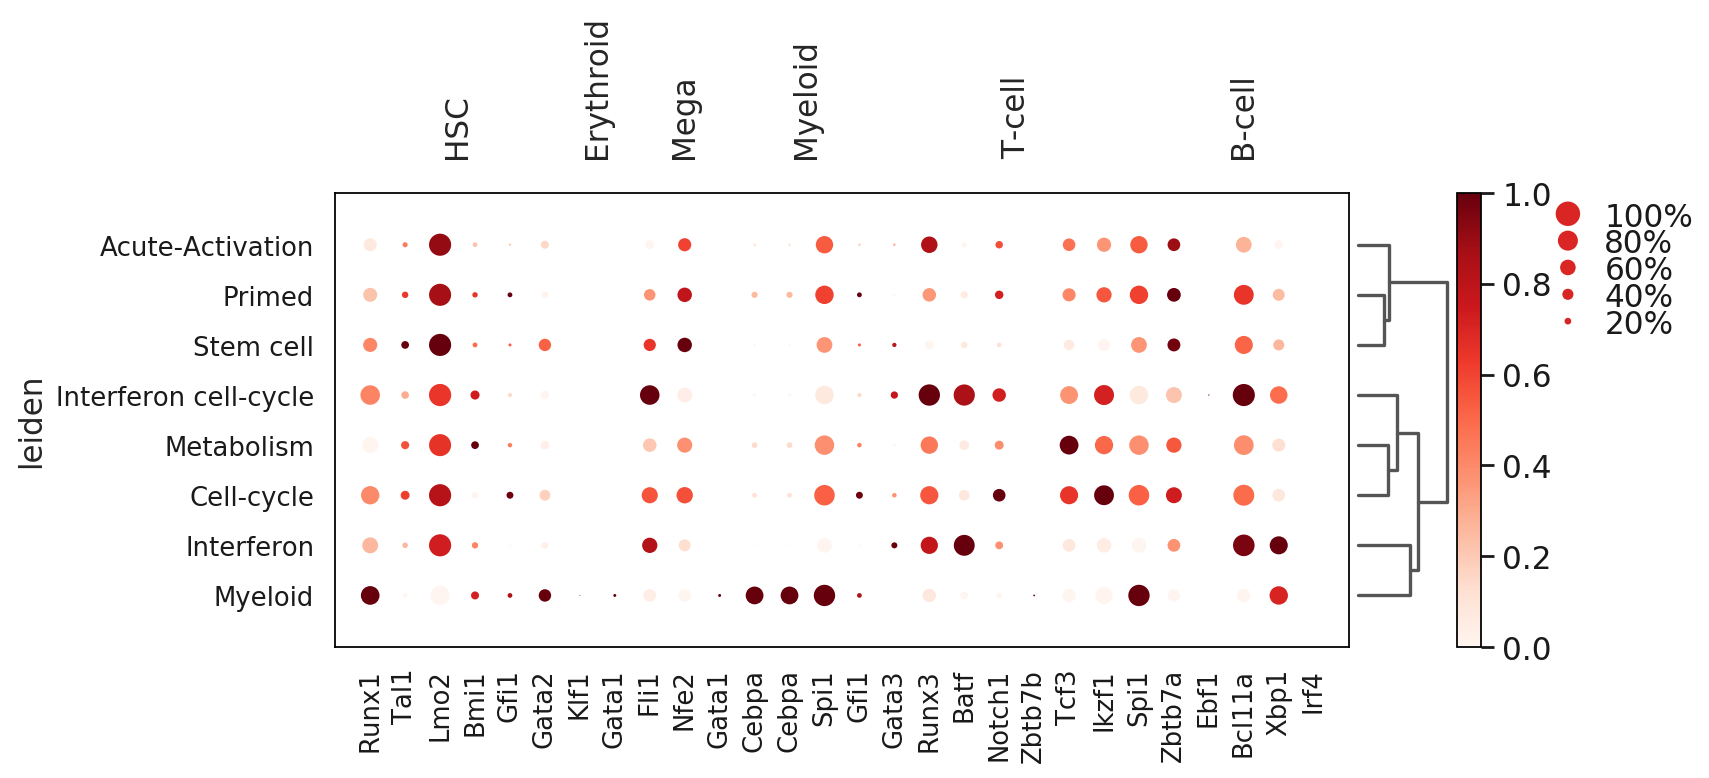

GridSpec(2, 5, height_ratios=[0.5, 10], width_ratios=[8.25, 0.8, 0.2, 0.5, 0.25])

In [20]:
sc.pl.dotplot(adata, lin_tf, groupby='leiden',standard_scale='var', figsize = (10, 4), 
              save='_MPP_TF_factors.pdf', dendrogram=True)

## pIC

In [21]:
# Read files and check how many genes there are in HSCs for each cutoff

diff_genes = pd.read_csv('./write/pIC_combo_HSCs_MPPs_nocutoff.csv')
diff_genes = diff_genes[diff_genes['specific'] != 'HSC_only']
print('all differentially expressed genes')
print(len(diff_genes))

diff_genes = pd.read_csv('./write/pIC_combo_HSCs_MPPs_1.2.csv')
diff_genes = diff_genes[diff_genes['specific'] != 'HSC_only']
print('differentially expressed genes 1.2 fold')
print(len(diff_genes))

diff_genes = pd.read_csv('./write/pIC_combo_HSCs_MPPs_1.5.csv')
diff_genes = diff_genes[diff_genes['specific'] != 'HSC_only']
print('differentially expressed genes 1.5 fold')
print(len(diff_genes))

all differentially expressed genes
2798
differentially expressed genes 1.2 fold
375
differentially expressed genes 1.5 fold
97


In [22]:
# choose 1.5 fold
diff_genes = pd.read_csv('./write/pIC_combo_HSCs_MPPs_1.5.csv')
diff_genes = diff_genes[diff_genes['specific'] != 'HSC_only']

# make dictonary from marker genes
pIC_dict = diff_genes.groupby('specific')['primerid'].apply(list).to_dict()

# calculate average expression per cluster
pIC_avg = average_expression(adata, pIC_dict, gene_symbol_key=None, partition_key='cluster_sample')

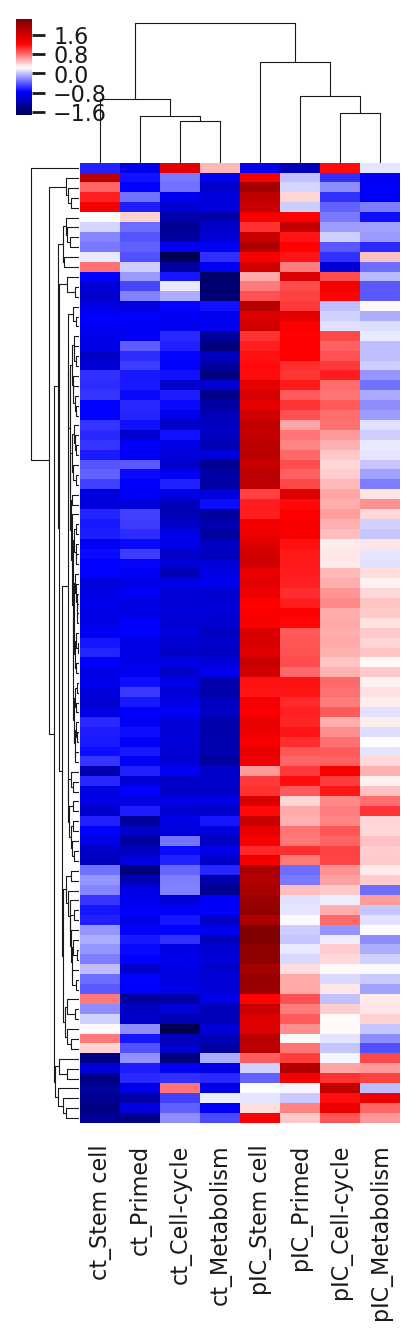

In [23]:
sns_plot = sns.clustermap(pIC_avg[['pIC_Cell-cycle',
                                     'pIC_Metabolism',
                                     'pIC_Primed',
                                     'pIC_Stem cell',
                                     'ct_Cell-cycle',
                                     'ct_Metabolism',
                                     'ct_Primed',
                                     'ct_Stem cell']],
                          col_cluster=True,
                          figsize= (2, 6),
                          z_score=0,
                          method= 'average',
                          metric = 'euclidean',
                          cmap = 'seismic',
                          xticklabels=True,
                          yticklabels=False
                         )

#resize clustermap
ax_heatmap_orig_pos = sns_plot.ax_heatmap.get_position()
sns_plot.ax_heatmap.set_position([ax_heatmap_orig_pos.x0, ax_heatmap_orig_pos.y0, 
                                  1, 1])

# resize dendrograms to match
ax_row_orig_pos = sns_plot.ax_row_dendrogram.get_position()
sns_plot.ax_row_dendrogram.set_position([ax_row_orig_pos.x0, ax_row_orig_pos.y0, 
                                     ax_row_orig_pos.width, 1])
ax_col_orig_pos = sns_plot.ax_col_dendrogram.get_position()
sns_plot.ax_col_dendrogram.set_position([ax_col_orig_pos.x0, ax_heatmap_orig_pos.y0 + 1,
                                     1, ax_col_orig_pos.height])


# moves the color bar and changes the font size
#[distance horizontal, distance vertical, width horizontal, width vertical]
sns_plot.cax.set_position([ax_heatmap_orig_pos.x0 - 0.2, ax_heatmap_orig_pos.y0 + 1.05, 
                                  .05, .1])
plt.setp(sns_plot.cax.yaxis.get_majorticklabels(), fontsize=10) 

plt.setp(sns_plot.ax_heatmap.get_yticklabels(), fontsize = 5)  # For y axis
plt.setp(sns_plot.ax_heatmap.get_xticklabels(), fontsize = 10)  # For y axis

#sns_plot.cax.set_position([1, .75, .03, .03])

#sns_plot.ax_heatmap.annotate('local max', xy=(2, 1), xytext=(3, 1.5),
           # arrowprops=dict(facecolor='black', shrink=0.05),
            #)

#plt.setp(sns_plot.cax.yaxis.get_majorticklabels(), fontsize=10) 
sns_plot.savefig("./figures/MPP_pIC_1.5_heatmap_all_genes_condensed.pdf", dpi=300)

In [24]:
# define categories and colors for plotting (make a look up table = lut)
lut = dict(zip(pIC_avg['specific'].unique(), ["black", "lightgray"]))
row_colors = pIC_avg['specific'].map(lut)

<Figure size 320x320 with 0 Axes>

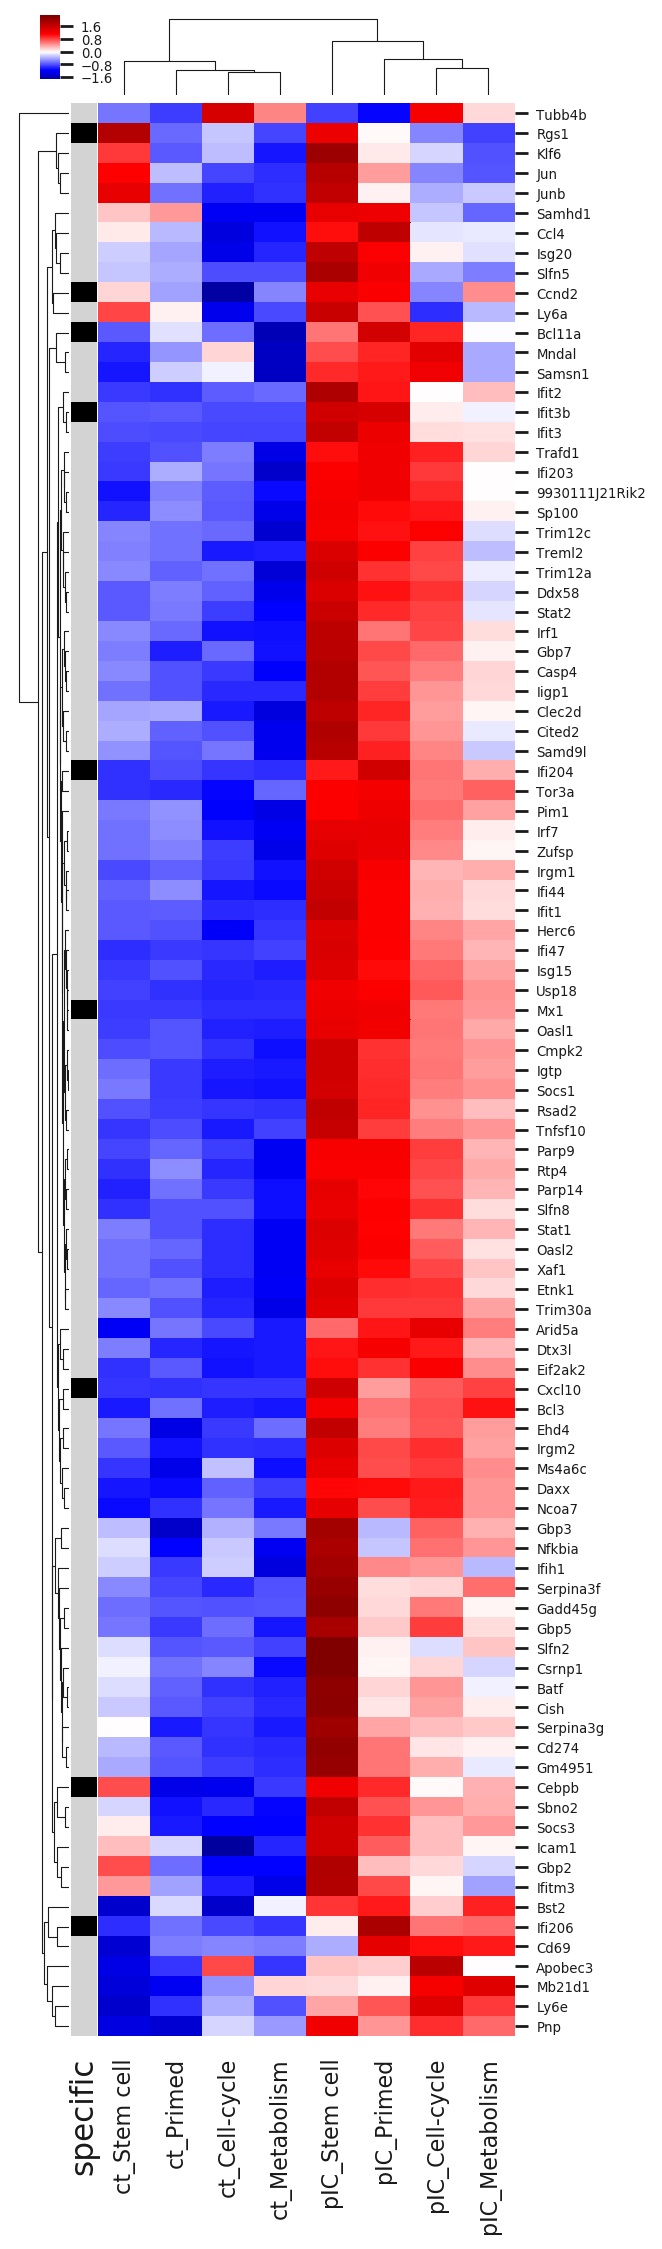

In [25]:
# larger - with gene names
plt.figure()
sns_plot = sns.clustermap(pIC_avg[['pIC_Cell-cycle',
                                     'pIC_Metabolism',
                                     'pIC_Primed',
                                     'pIC_Stem cell',
                                     'ct_Cell-cycle',
                                     'ct_Metabolism',
                                     'ct_Primed',
                                     'ct_Stem cell']],
                            row_cluster=True,
                            col_cluster=True,
                            cmap = 'seismic', 
                            figsize= (4, 20),
                            row_colors=row_colors,
                            z_score=0,
                            center = 0,
                            #annot=True, 
                            yticklabels=True)

sns_plot.ax_row_dendrogram.set_visible(True)
sns_plot.ax_col_dendrogram.set_visible(True)
#sns_plot.cax.set_visible(False)

ax_col_orig_pos = sns_plot.ax_col_dendrogram.get_position()
sns_plot.ax_col_dendrogram.set_position([ax_col_orig_pos.x0, ax_col_orig_pos.y0,
                                     0.65, 0.025])

sns_plot.cax.set_position([ax_col_orig_pos.x0 - 0.09, ax_col_orig_pos.y0 + 0.005, 
                                  .03, 0.02])
plt.setp(sns_plot.cax.yaxis.get_majorticklabels(), fontsize=6) 


plt.setp(sns_plot.ax_heatmap.get_yticklabels(), fontsize = 6)  # For y axis
plt.setp(sns_plot.ax_heatmap.get_xticklabels(), fontsize = 10)  # For y axis
sns_plot.savefig("./figures/MPP_pIC_1.5_heatmap_all_genes_long.pdf", dpi=300)

## GCSF

In [26]:
# Read files and check how many genes there are in HSCs for each cutoff

diff_genes = pd.read_csv('./write/GCSF_combo_HSCs_MPPs_nocutoff.csv')
diff_genes = diff_genes[diff_genes['specific'] != 'HSC_only']
print('all differentially expressed genes')
print(len(diff_genes))

diff_genes = pd.read_csv('./write/GCSF_combo_HSCs_MPPs_1.2.csv')
diff_genes = diff_genes[diff_genes['specific'] != 'HSC_only']
print('differentially expressed genes 1.2 fold')
print(len(diff_genes))

diff_genes = pd.read_csv('./write/GCSF_combo_HSCs_MPPs_1.5.csv')
diff_genes = diff_genes[diff_genes['specific'] != 'HSC_only']
print('differentially expressed genes 1.5 fold')
print(len(diff_genes))

all differentially expressed genes
3892
differentially expressed genes 1.2 fold
953
differentially expressed genes 1.5 fold
87


In [27]:
# choose 1.5 fold
diff_genes = pd.read_csv('./write/GCSF_combo_HSCs_MPPs_1.5.csv')
diff_genes = diff_genes[diff_genes['specific'] != 'HSC_only']

# make dictonary from marker genes
GCSF_dict = diff_genes.groupby('specific')['primerid'].apply(list).to_dict()

# calculate average expression per cluster
GCSF_avg = average_expression(adata, GCSF_dict, gene_symbol_key=None, partition_key='cluster_sample')

In [28]:
# define categories and colors for plotting (make a look up table = lut)
lut = dict(zip(GCSF_avg['specific'].unique(), ["black", "lightgray"]))
row_colors = GCSF_avg['specific'].map(lut)

<Figure size 320x320 with 0 Axes>

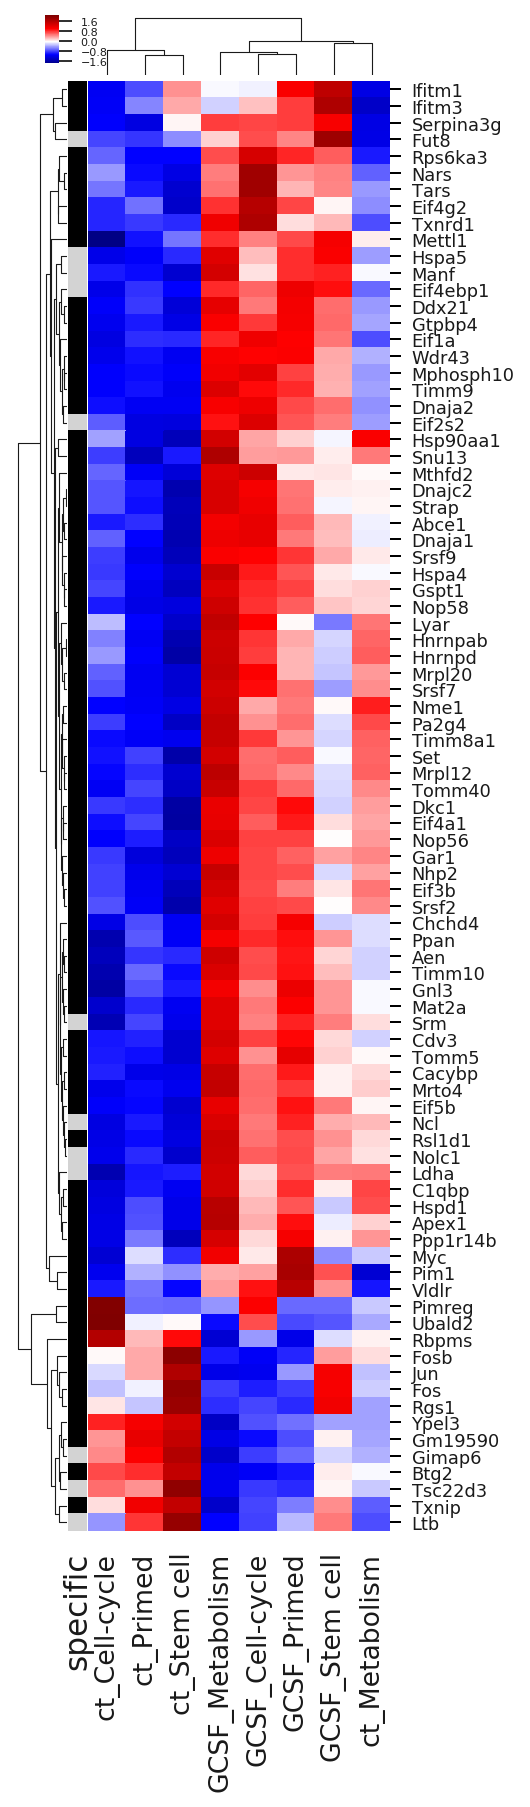

In [29]:
# larger - with gene names
plt.figure()
sns_plot = sns.clustermap(GCSF_avg[['GCSF_Cell-cycle',
                                     'GCSF_Metabolism',
                                     'GCSF_Primed',
                                     'GCSF_Stem cell',
                                     'ct_Cell-cycle',
                                     'ct_Metabolism',
                                     'ct_Primed',
                                     'ct_Stem cell']],
                            row_cluster=True,
                            col_cluster=True,
                            cmap = 'seismic', 
                            figsize= (3, 15),
                            row_colors=row_colors,
                            z_score=0,
                            center = 0,
                            #annot=True, 
                            yticklabels=True)

sns_plot.ax_row_dendrogram.set_visible(True)
sns_plot.ax_col_dendrogram.set_visible(True)

ax_col_orig_pos = sns_plot.ax_col_dendrogram.get_position()
sns_plot.ax_col_dendrogram.set_position([ax_col_orig_pos.x0, ax_col_orig_pos.y0,
                                     0.63, 0.025])

sns_plot.cax.set_position([ax_col_orig_pos.x0 - 0.09, ax_col_orig_pos.y0 + 0.005, 
                                  .03, 0.02])
sns_plot.cax.tick_params(width = 0.8, labelsize= 5)


plt.setp(sns_plot.ax_heatmap.yaxis.get_ticklines(), 'markersize', 5)
plt.setp(sns_plot.ax_heatmap.yaxis.get_ticklines(), 'markeredgewidth', 0.9)
plt.setp(sns_plot.ax_heatmap.yaxis.get_ticklines(), color='black')

plt.setp(sns_plot.ax_heatmap.get_yticklabels(), fontsize = 8)  # For y axis
plt.setp(sns_plot.ax_heatmap.get_xticklabels(), fontsize = 12)  # For y axis
sns_plot.savefig("./figures/MPP_GCSF_1.5_heatmap_all_genes_long.pdf", dpi=300)

In [30]:
# choose 1.2 fold
diff_genes = pd.read_csv('./write/GCSF_combo_HSCs_MPPs_1.2.csv')
diff_genes = diff_genes[diff_genes['specific'] != 'HSC_only']

# make dictonary from marker genes
GCSF_dict = diff_genes.groupby('specific')['primerid'].apply(list).to_dict()

# calculate average expression per cluster
GCSF_avg = average_expression(adata, GCSF_dict, gene_symbol_key=None, partition_key='cluster_sample')

In [31]:
# define categories and colors for plotting (make a look up table = lut)
lut = dict(zip(GCSF_avg['specific'].unique(), ["black", "lightgray"]))
row_colors = GCSF_avg['specific'].map(lut)

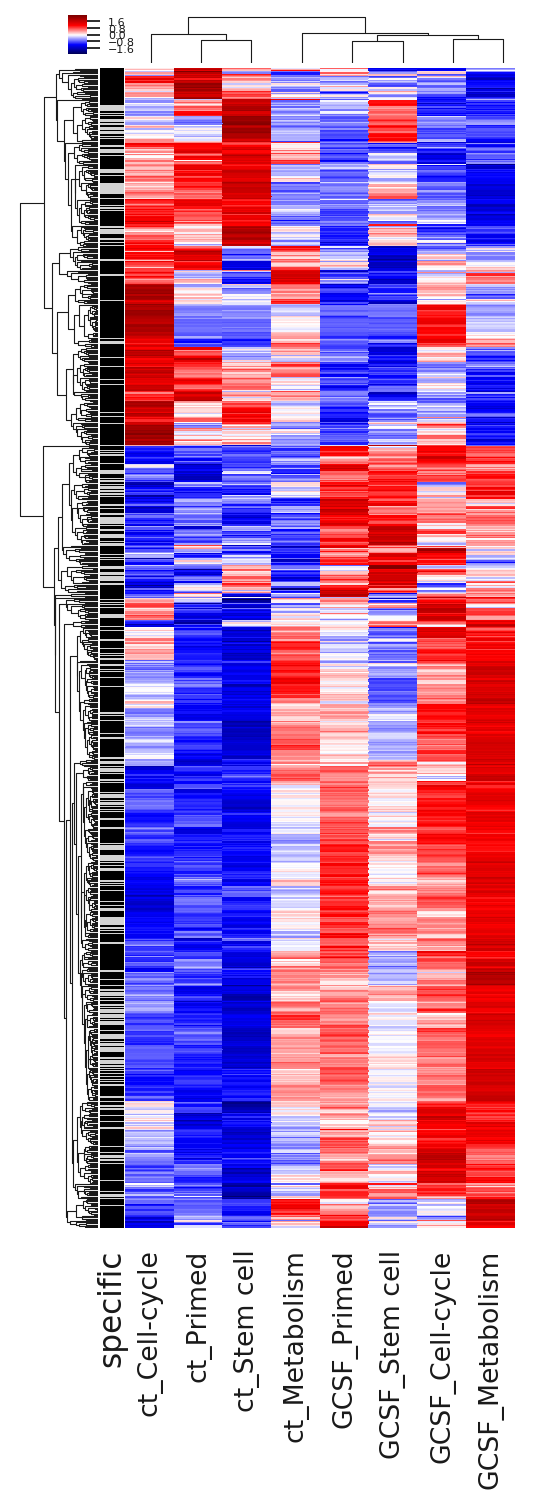

In [32]:
sns_plot = sns.clustermap(GCSF_avg[['GCSF_Cell-cycle',
                                     'GCSF_Metabolism',
                                     'GCSF_Primed',
                                     'GCSF_Stem cell',
                                     'ct_Cell-cycle',
                                     'ct_Metabolism',
                                     'ct_Primed',
                                     'ct_Stem cell']],
                            row_cluster=True,
                            col_cluster=True,
                            cmap = 'seismic', 
                            figsize= (4, 12),
                            row_colors=row_colors,
                            z_score=0,
                            center = 0,
                            #annot=True, 
                            yticklabels=False)

sns_plot.ax_row_dendrogram.set_visible(True)
sns_plot.ax_col_dendrogram.set_visible(True)

ax_col_orig_pos = sns_plot.ax_col_dendrogram.get_position()
sns_plot.ax_col_dendrogram.set_position([ax_col_orig_pos.x0, ax_col_orig_pos.y0,
                                     0.63, 0.025])

sns_plot.cax.set_position([ax_col_orig_pos.x0 - 0.09, ax_col_orig_pos.y0 + 0.005, 
                                  .03, 0.02])
sns_plot.cax.tick_params(width = 0.8, labelsize= 5)


plt.setp(sns_plot.ax_heatmap.yaxis.get_ticklines(), 'markersize', 5)
plt.setp(sns_plot.ax_heatmap.yaxis.get_ticklines(), 'markeredgewidth', 0.9)
plt.setp(sns_plot.ax_heatmap.yaxis.get_ticklines(), color='black')

plt.setp(sns_plot.ax_heatmap.get_yticklabels(), fontsize = 8)  # For y axis
plt.setp(sns_plot.ax_heatmap.get_xticklabels(), fontsize = 12)  # For y axis
sns_plot.savefig("./figures/MPP_GCSF_1.1_heatmap_all_genes_short.pdf", dpi=300)

In [33]:
# this generates a list of genes ordered by the clustering

avg_df = GCSF_avg[['ct_Cell-cycle',
                'ct_Primed',
                'ct_Stem cell',
                'ct_Metabolism',
                'GCSF_Primed',
                'GCSF_Stem cell',
                'GCSF_Cell-cycle',
                 'GCSF_Metabolism',
                ]]

genes_df = pd.DataFrame(avg_df.index.tolist())
genes_df['index1'] = genes_df.index
neworder_df = pd.DataFrame(sns_plot.dendrogram_row.reordered_ind, columns = ['index1'])
orderedbycluster = pd.merge(neworder_df, genes_df, how='inner', on='index1')
orderedbycluster = orderedbycluster.rename(columns={0: 'gene'})

# make a new df with the genes ordered with this clustering (so does not need to be clustered before plotting)
avg_df_neworder = pd.merge(avg_df, orderedbycluster, how='right', left_index= True, right_on='gene')
avg_df_neworder = avg_df_neworder.set_index(['gene'])
avg_df_neworder = avg_df_neworder.drop(['index1'], axis=1) 

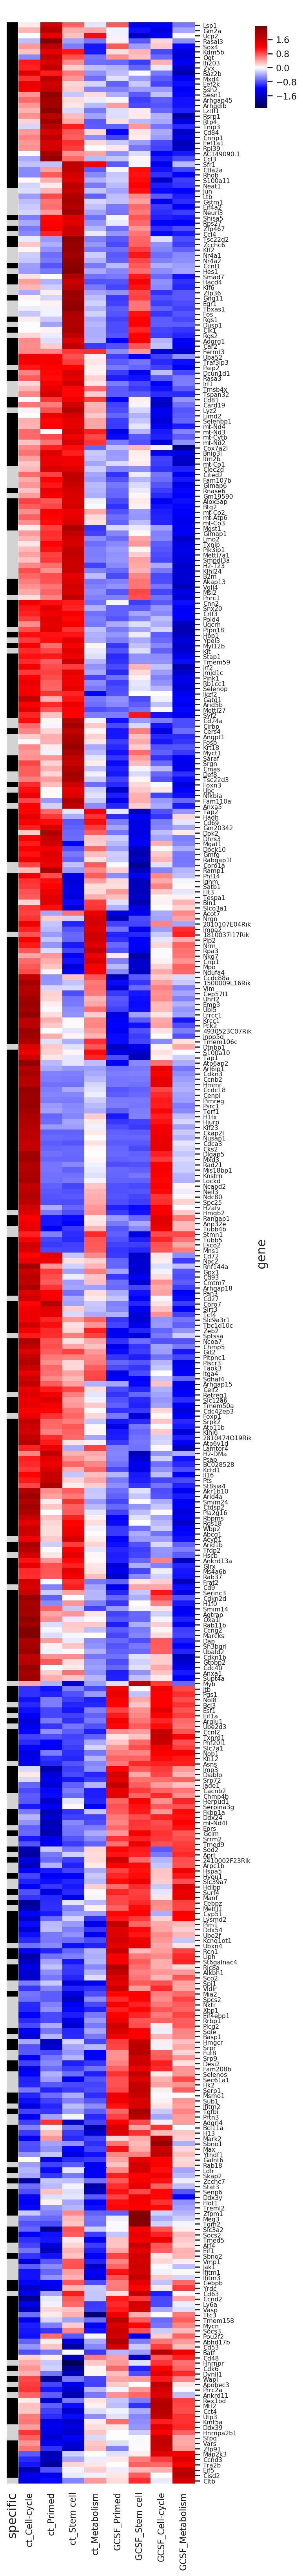

In [34]:
# plot first part of the heatmap

sns_plot = sns.clustermap(avg_df_neworder.iloc[0:460,:], 
                        col_cluster=False, 
                        row_cluster=False, 
                        cmap = 'seismic', 
                        figsize= (4, 65),
                        row_colors=row_colors,
                        z_score=0,
                        center = 0,
                        annot=False, 
                        yticklabels=True)

sns_plot.ax_row_dendrogram.set_visible(False)
#sns_plot.cax.set_visible(False)

#removes the whitespace on top of the heatmap
col = sns_plot.ax_col_dendrogram.get_position()
sns_plot.ax_col_dendrogram.set_position([col.x0, col.y0, col.width, col.height*0.01])

# moves the color bar and changes the font size
#[distance horizontal, distance vertical, width horizontal, width vertical]
sns_plot.cax.set_position([1.2, .733, .05, .02])
plt.setp(sns_plot.cax.yaxis.get_majorticklabels(), fontsize=10) 

plt.setp(sns_plot.ax_heatmap.get_yticklabels(), fontsize = 7)  # For y axis
plt.setp(sns_plot.ax_heatmap.get_xticklabels(), fontsize = 10)  # For y axis

plt.show()
sns_plot.savefig("./figures/MPP_GCSF_1.2_heatmap_all_genes_long_part1.pdf", dpi=300)

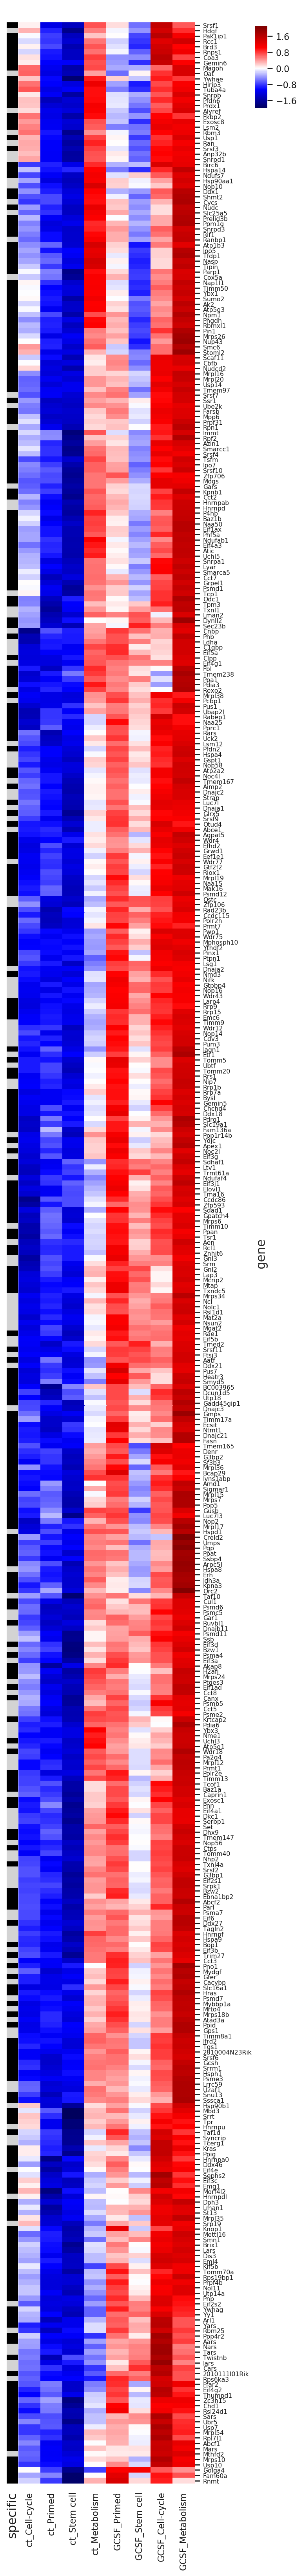

In [35]:
# plot second part of the heatmap

sns_plot = sns.clustermap(avg_df_neworder.iloc[461:920,:], 
                        col_cluster=False, 
                        row_cluster=False, 
                        cmap = 'seismic', 
                        figsize= (4, 65),
                        z_score=0,
                        row_colors=row_colors,
                        center = 0,
                        annot=False, 
                        yticklabels=True)

sns_plot.ax_row_dendrogram.set_visible(False)
#sns_plot.cax.set_visible(False)

#removes the whitespace on top of the heatmap
col = sns_plot.ax_col_dendrogram.get_position()
sns_plot.ax_col_dendrogram.set_position([col.x0, col.y0, col.width, col.height*0.01])

# moves the color bar and changes the font size
#[distance horizontal, distance vertical, width horizontal, width vertical]
sns_plot.cax.set_position([1.2, .733, .05, .02])
plt.setp(sns_plot.cax.yaxis.get_majorticklabels(), fontsize=10) 

plt.setp(sns_plot.ax_heatmap.get_yticklabels(), fontsize = 7)  # For y axis
plt.setp(sns_plot.ax_heatmap.get_xticklabels(), fontsize = 10)  # For y axis

plt.show()
sns_plot.savefig("./figures/MPP_GCSF_1.2_heatmap_all_genes_long_part2.pdf", dpi=300)

old
gen = ['Stat3', 'Plcg2']
rib = ['Snu13',
 'Ppan',
 'Lyar',
 'Mrpl20',
 'Rsl1d1',
 'Mphosph10',
 'Nop58',
 'C1qbp',
 'Nop56',
 'Pa2g4',
 'Ncl',
 'Abce1',
 'Mrto4',
 'Dkc1',
 'Gar1',
 'Nhp2']
trans = ['Eif3b',
 'Eif4ebp1',
 'Eif4a1',
 'Eif5b',
 'Eif3a',
 'Eif2s2']
hsp = ['Hspa5',
 'Dnajc2',
 'Dnaja1',
 'Hsp90aa1',
 'Hspd1']
mito = [ 'Tomm40',
 'Timm10',
 'Tomm5',
 'Timm9',
 'Timm8a1']



In [36]:
gen = ['Stat3', 'Plcg2', 'Spi1', 'Myb']
rib = [
 'Nop14',
 'Nip7',
 'Wdr43',
 'Wdr12']
tranl = ['Eif4ebp1', 'Eif4ebp2','Eif3a', 'Eif3g']
splic = ['Srsf7', 'Srsf2', 'Sf3b1']
hsp = ['Hspa5',
 'Dnajc2',
 'Dnaja1',
 'Hsp90aa1',
 'Hspd1']

In [37]:
GCSF_dic = {'general induction': gen,
            'ribosome biogenesis genes': rib,
           'translation initiation': tranl,
           'protein folding': hsp,
           'splicing' :splic
            }

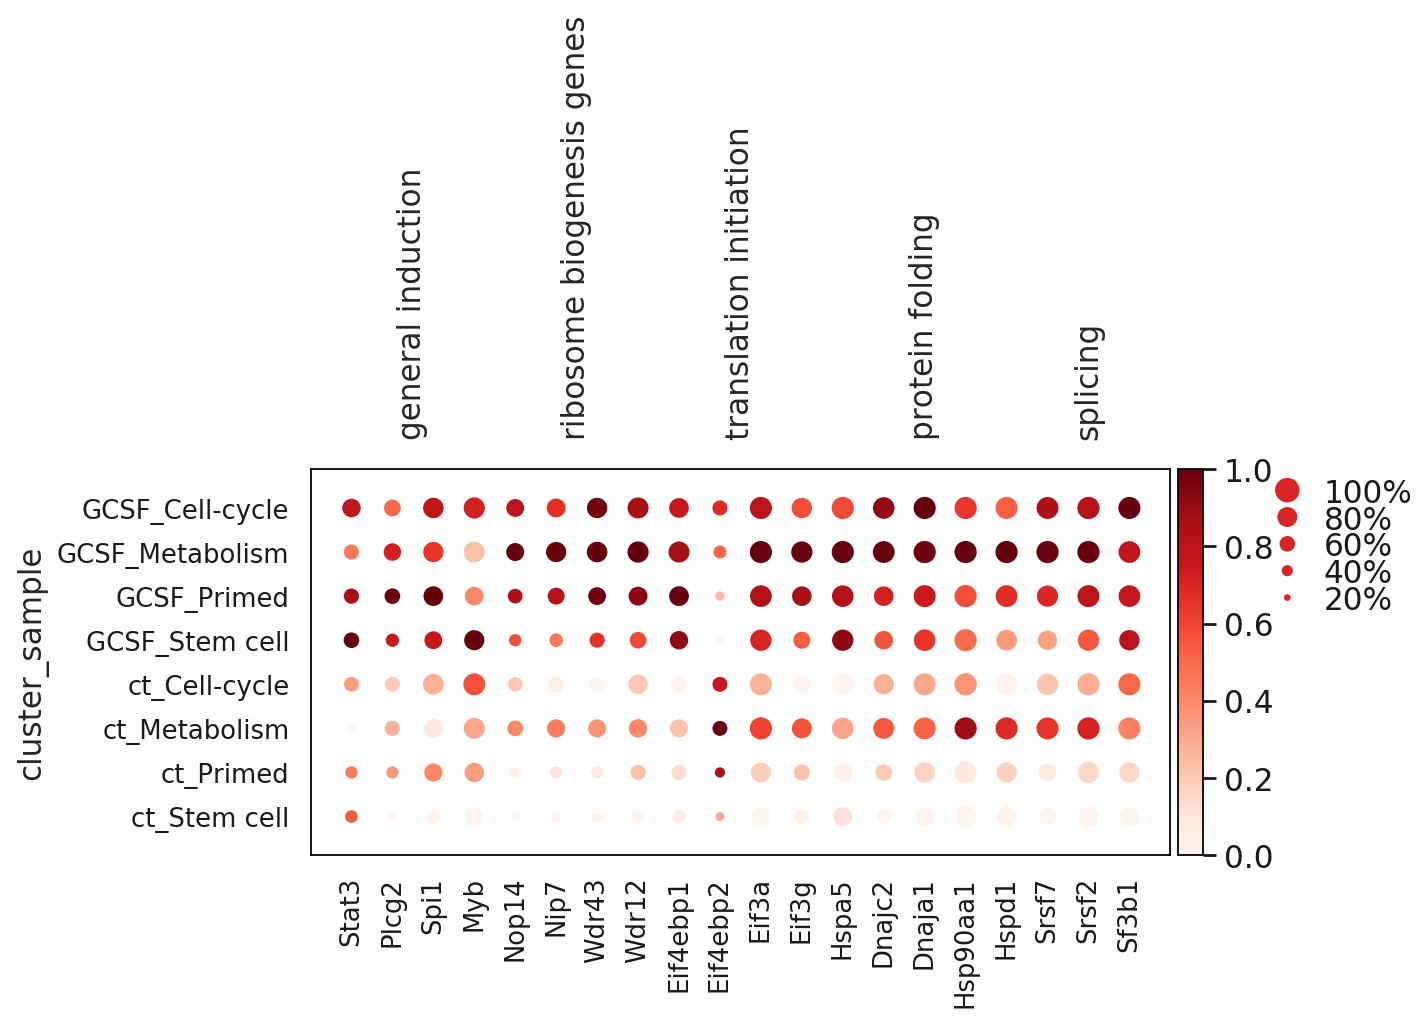

GridSpec(2, 5, height_ratios=[0.5, 10], width_ratios=[7.0, 0, 0.2, 0.5, 0.25])

In [38]:
sc.pl.dotplot(adata[(adata.obs['cluster_sample']=='ct_Stem cell') |
                           (adata.obs['cluster_sample']=='ct_Primed') |
                           (adata.obs['cluster_sample']=='ct_Metabolism') |
                           (adata.obs['cluster_sample']=='ct_Cell-cycle') |
                           
                           (adata.obs['cluster_sample']=='GCSF_Stem cell') |
                           (adata.obs['cluster_sample']=='GCSF_Primed') |
                           (adata.obs['cluster_sample']=='GCSF_Metabolism') |
                           (adata.obs['cluster_sample']=='GCSF_Cell-cycle')], 
                 GCSF_dic, groupby='cluster_sample', standard_scale = 'var')

#| (adata.obs['cluster_sample']=='GCSF_Interferon') | (adata.obs['cluster_sample']=='ct_Interferon')

## indo

In [39]:
# Read files and check how many genes there are in HSCs for each cutoff

diff_genes = pd.read_csv('./write/indo_combo_HSCs_MPPs_nocutoff.csv')
diff_genes = diff_genes[diff_genes['specific'] != 'HSC_only']
print('all differentially expressed genes')
print(len(diff_genes))

diff_genes = pd.read_csv('./write/indo_combo_HSCs_MPPs_1.2.csv')
diff_genes = diff_genes[diff_genes['specific'] != 'HSC_only']
print('differentially expressed genes 1.2 fold')
print(len(diff_genes))

diff_genes = pd.read_csv('./write/indo_combo_HSCs_MPPs_1.5.csv')
diff_genes = diff_genes[diff_genes['specific'] != 'HSC_only']
print('differentially expressed genes 1.5 fold')
print(len(diff_genes))

all differentially expressed genes
28
differentially expressed genes 1.2 fold
0
differentially expressed genes 1.5 fold
0


In [40]:
diff_genes = pd.read_csv('./write/indo_combo_HSCs_MPPs_1.2.csv')
diff_genes = diff_genes[diff_genes['specific'] != 'HSC_only']
diff_genes

,primerid,HSC_any,MPP_any,overlap,specific


## dmPGE2

In [41]:
# Read files and check how many genes there are in HSCs for each cutoff

diff_genes = pd.read_csv('./write/dmPGE2_combo_HSCs_MPPs_nocutoff.csv')
diff_genes = diff_genes[diff_genes['specific'] != 'HSC_only']
print('all differentially expressed genes')
print(len(diff_genes))

diff_genes = pd.read_csv('./write/dmPGE2_combo_HSCs_MPPs_1.2.csv')
diff_genes = diff_genes[diff_genes['specific'] != 'HSC_only']
print('differentially expressed genes 1.2 fold')
print(len(diff_genes))

diff_genes = pd.read_csv('./write/dmPGE2_combo_HSCs_MPPs_1.5.csv')
diff_genes = diff_genes[diff_genes['specific'] != 'HSC_only']
print('differentially expressed genes 1.5 fold')
print(len(diff_genes))

all differentially expressed genes
3050
differentially expressed genes 1.2 fold
631
differentially expressed genes 1.5 fold
110


In [42]:
# choose 1.5 fold
diff_genes = pd.read_csv('./write/dmPGE2_combo_HSCs_MPPs_1.5.csv')
diff_genes = diff_genes[diff_genes['specific'] != 'HSC_only']

# make dictonary from marker genes
dmPGE2_dict = diff_genes.groupby('specific')['primerid'].apply(list).to_dict()

# calculate average expression per cluster
dmPGE2_avg = average_expression(adata, dmPGE2_dict, gene_symbol_key=None, partition_key='cluster_sample')

In [43]:
# define categories and colors for plotting (make a look up table = lut)
lut = dict(zip(dmPGE2_avg['specific'].unique(), ["black", "lightgray"]))
row_colors = dmPGE2_avg['specific'].map(lut)

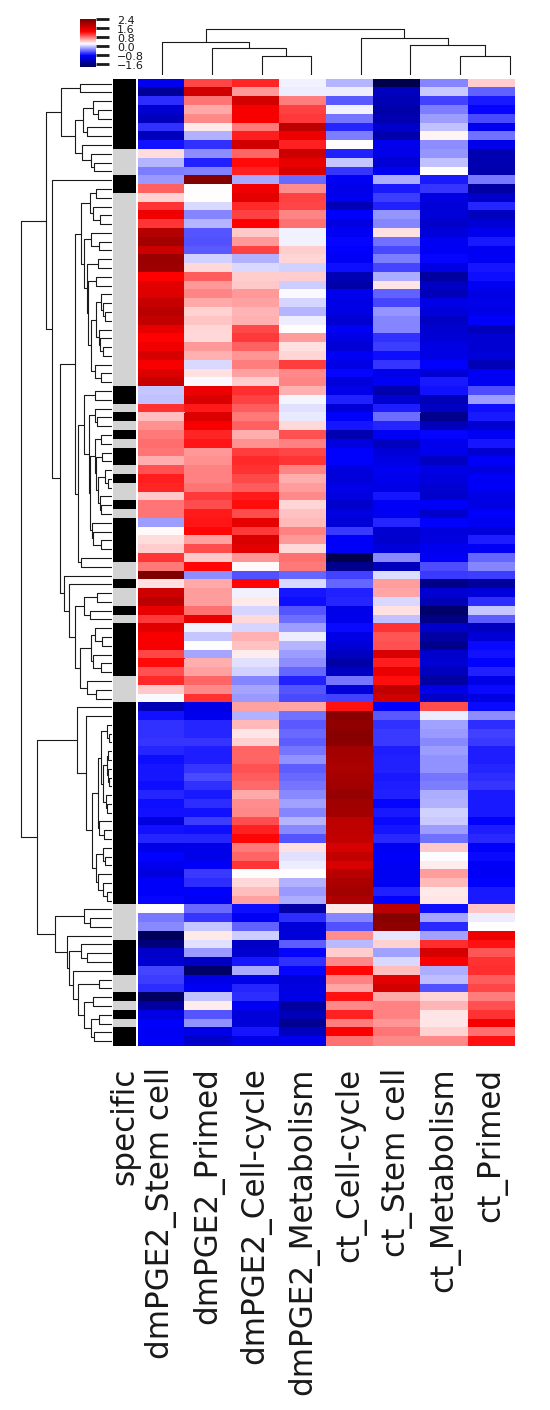

In [44]:
sns_plot = sns.clustermap(dmPGE2_avg[['dmPGE2_Cell-cycle',
                                     'dmPGE2_Metabolism',
                                     'dmPGE2_Primed',
                                     'dmPGE2_Stem cell',
                                     'ct_Cell-cycle',
                                     'ct_Metabolism',
                                     'ct_Primed',
                                     'ct_Stem cell']],
                          col_cluster=True,
                          figsize= (4, 10),
                          z_score=0,
                          method= 'average',
                          row_colors=row_colors,
                          metric = 'euclidean',
                          cmap = 'seismic',
                          yticklabels=False)


ax_col_orig_pos = sns_plot.ax_col_dendrogram.get_position()
sns_plot.ax_col_dendrogram.set_position([ax_col_orig_pos.x0, ax_col_orig_pos.y0,
                                     0.62, 0.03])

sns_plot.cax.set_position([ax_col_orig_pos.x0 - 0.09, ax_col_orig_pos.y0 + 0.005, 
                                    .025, .03])
plt.setp(sns_plot.cax.yaxis.get_majorticklabels(), fontsize=5)
sns_plot.savefig("./figures/MPP_dmPGE2_1.5_heatmap_all_genes_condensed.pdf", dpi=300)

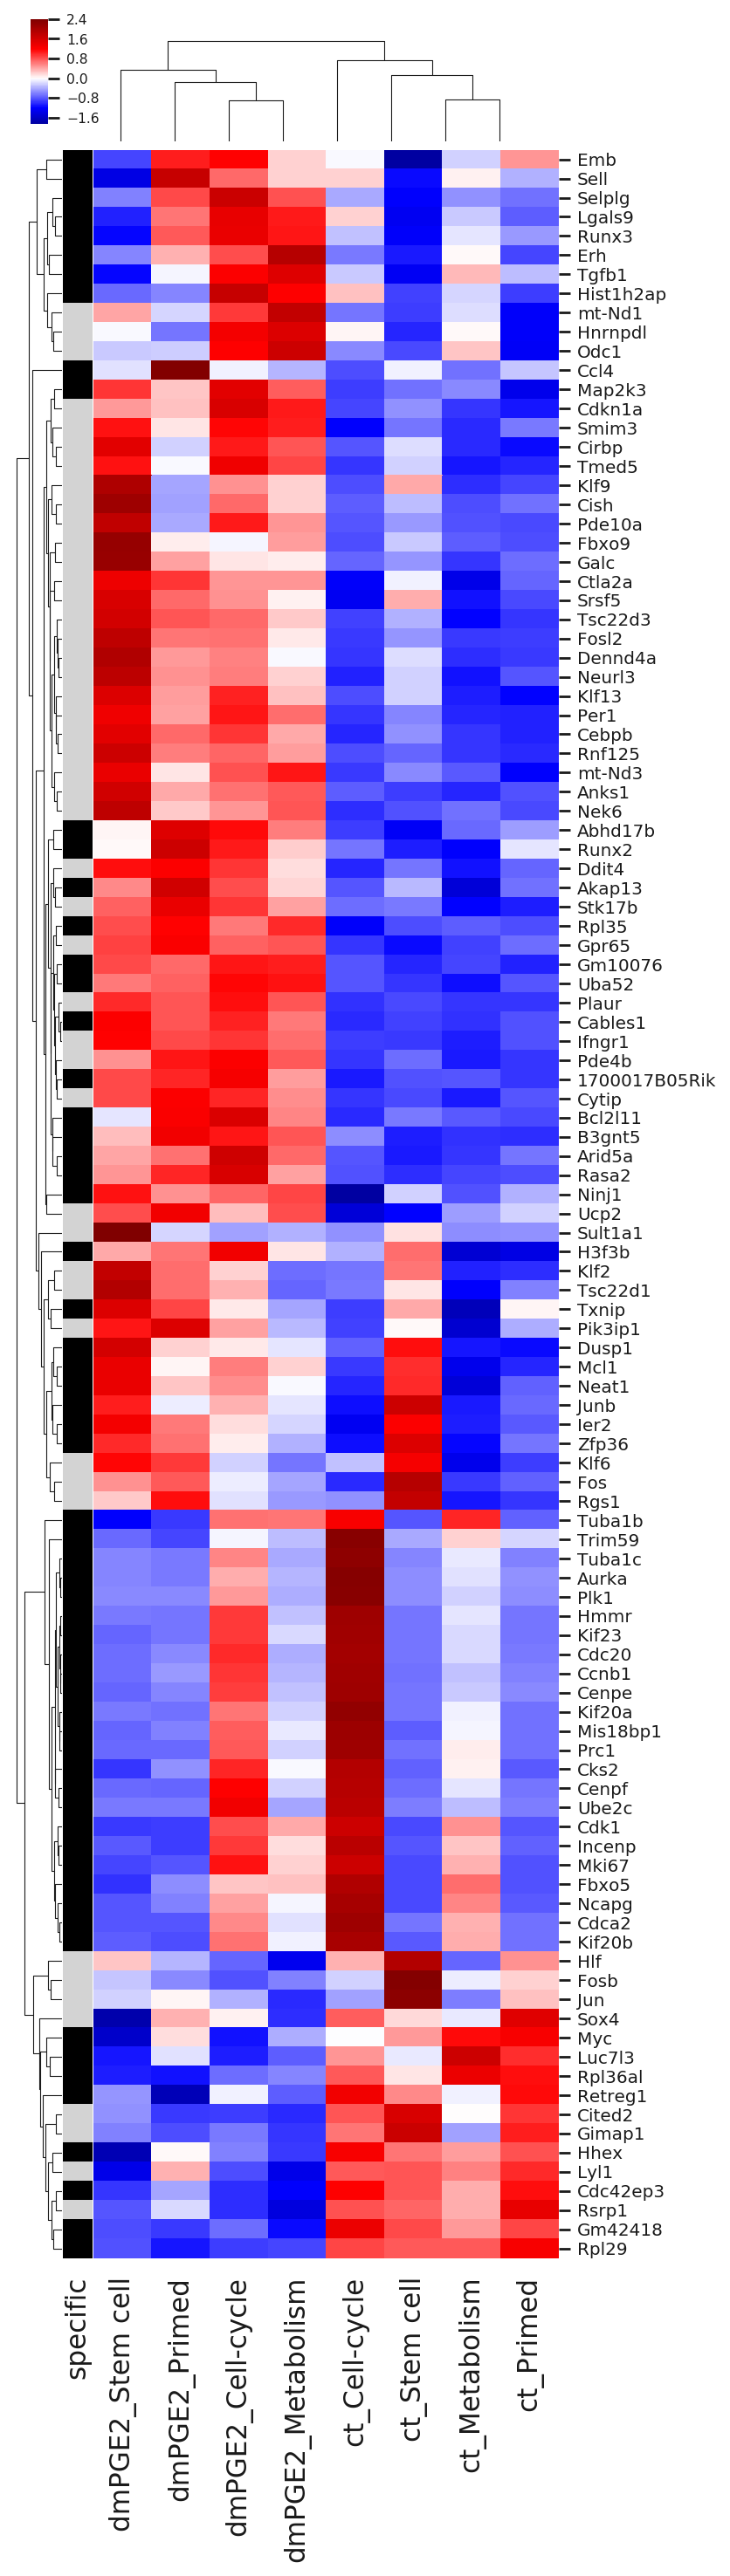

In [45]:
# larger - with gene names

sns_plot = sns.clustermap(dmPGE2_avg[['dmPGE2_Cell-cycle',
                                     'dmPGE2_Metabolism',
                                     'dmPGE2_Primed',
                                     'dmPGE2_Stem cell',
                                     'ct_Cell-cycle',
                                     'ct_Metabolism',
                                     'ct_Primed',
                                     'ct_Stem cell']],
                            cmap = 'seismic', 
                            figsize= (5, 25),
                            z_score=0,
                            center = 0,
                            row_colors=row_colors,
                            #annot=False, 
                            yticklabels=True)

sns_plot.ax_row_dendrogram.set_visible(True)
sns_plot.ax_col_dendrogram.set_visible(True)
#sns_plot.cax.set_visible(False)

ax_col_orig_pos = sns_plot.ax_col_dendrogram.get_position()
sns_plot.ax_col_dendrogram.set_position([ax_col_orig_pos.x0, ax_col_orig_pos.y0,
                                     0.62, 0.03])

sns_plot.cax.set_position([ax_col_orig_pos.x0 - 0.09, ax_col_orig_pos.y0 + 0.005, 
                                    .025, .03])
plt.setp(sns_plot.cax.yaxis.get_majorticklabels(), fontsize=7)



# moves the color bar and changes the font size
#[distance horizontal, distance vertical, width horizontal, width vertical]
#sns_plot.cax.set_position([1.1, .725, .03, .03])
#plt.setp(sns_plot.cax.yaxis.get_majorticklabels(), fontsize=10) 

plt.setp(sns_plot.ax_heatmap.get_yticklabels(), fontsize = 9)  # For y axis
plt.setp(sns_plot.ax_heatmap.get_xticklabels(), fontsize = 14)  # For y axis
sns_plot.savefig("./figures/MPP_dmPGE2_1.5_heatmap_all_genes_long.pdf", dpi=300)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


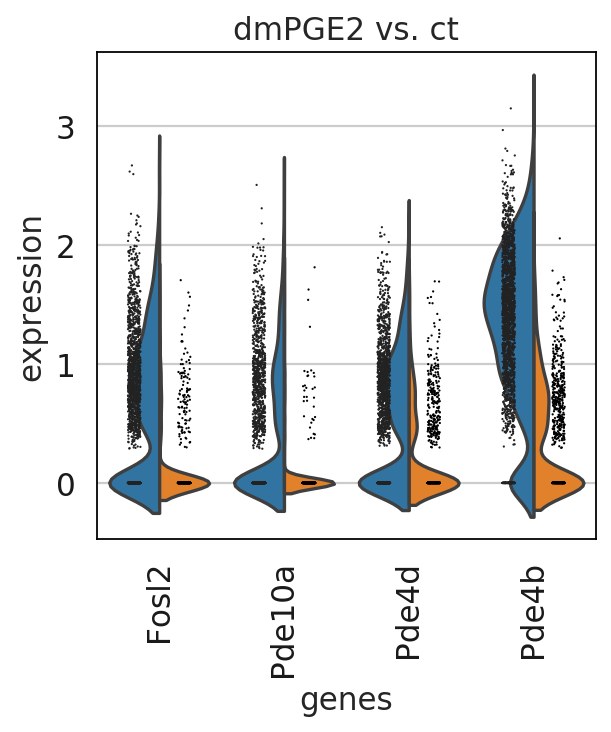

In [46]:
sc.tl.rank_genes_groups(adata, 'sample', groups = ['dmPGE2'], reference = 'ct', use_raw = True)
sc.pl.rank_genes_groups_violin(adata, groups=['dmPGE2'],
                               gene_names=['Fosl2', 'Pde10a', 'Pde4d', 'Pde4b'], jitter = True, save='_MPP_dmPGE2.pdf')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


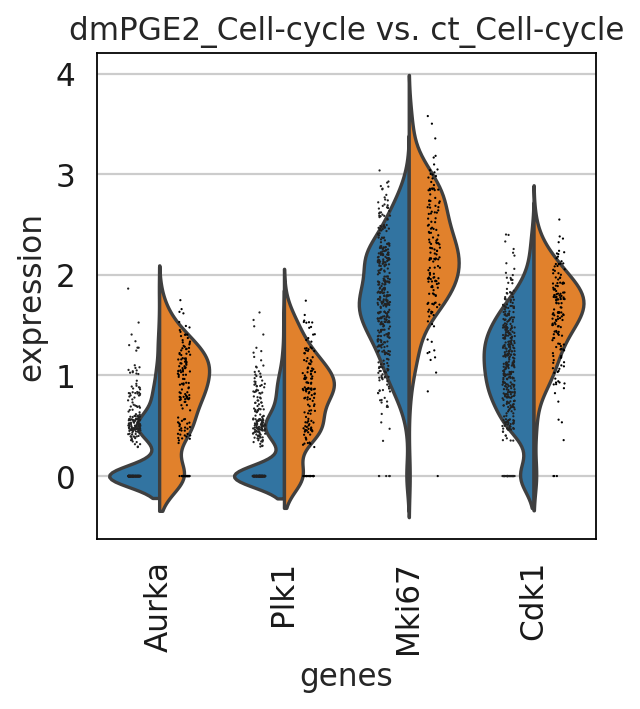

In [47]:
sc.tl.rank_genes_groups(adata, 'cluster_sample', groups = ['dmPGE2_Cell-cycle'], reference = 'ct_Cell-cycle', use_raw = True)
sc.pl.rank_genes_groups_violin(adata[(adata.obs['leiden']=='Cell-cycle')], groups=['dmPGE2_Cell-cycle'],
                               gene_names=['Aurka', 'Plk1', 'Mki67', 'Cdk1', ], jitter = True, save='_MPP_cellcycle_dmPGE2.pdf')

In [48]:
# Order of the lineage
lin = ('GCSF_Acute-Activation',
 'GCSF_Cell-cycle',
 'GCSF_Interferon',
 'GCSF_Interferon cell-cycle',
 'GCSF_Metabolism',
 'GCSF_Myeloid',
 'GCSF_Primed',
 'GCSF_Stem cell',
 'ct_Stem cell',
 'dmPGE2_Stem cell',
 'ct_Primed',
 'dmPGE2_Primed',
 'ct_Metabolism',
 'dmPGE2_Metabolism',
 'dmPGE2_Myeloid',
 'ct_Acute-Activation',
 'ct_Cell-cycle',
 'dmPGE2_Cell-cycle',
 'ct_Interferon',
 'ct_Myeloid',
 'dmPGE2_Acute-Activation', 
 'dmPGE2_Interferon',
 
 'indo_Acute-Activation',
 'indo_Cell-cycle',
 'indo_Interferon',
 'indo_Interferon cell-cycle',
 'indo_Metabolism',
 'indo_Myeloid',
 'indo_Primed',
 'indo_Stem cell',
 'pIC_Cell-cycle',
 'pIC_Interferon',
 'pIC_Interferon cell-cycle',
 'pIC_Metabolism',
 'pIC_Myeloid',
 'pIC_Primed',
 'pIC_Stem cell')


# Reordering leiden labels using Categorical data type
adata.obs['cluster_sample'] = adata.obs['cluster_sample'].cat.reorder_categories((lin), ordered=True)

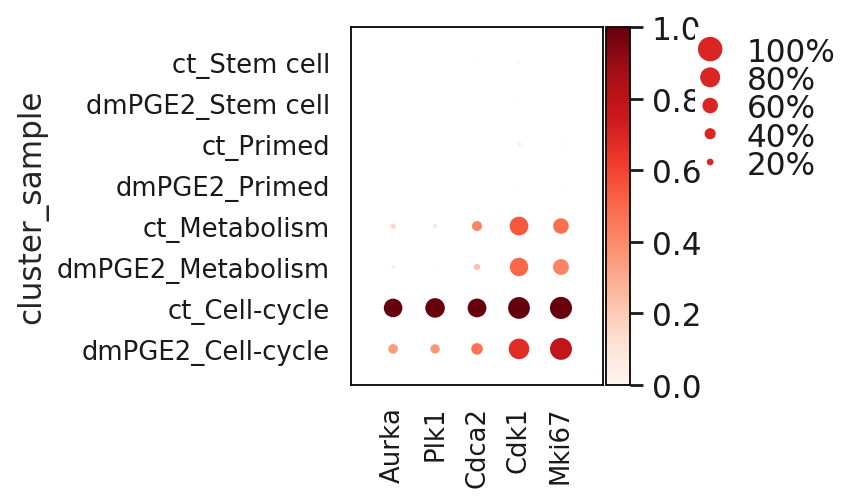

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[2.05, 0, 0.2, 0.5, 0.25])

In [49]:
sc.pl.dotplot(adata[(adata.obs['cluster_sample']=='ct_Stem cell') |
                           (adata.obs['cluster_sample']=='ct_Primed') |
                           (adata.obs['cluster_sample']=='ct_Metabolism') |
                           (adata.obs['cluster_sample']=='ct_Cell-cycle') |
                           
                           (adata.obs['cluster_sample']=='dmPGE2_Stem cell') |
                           (adata.obs['cluster_sample']=='dmPGE2_Primed') |
                           (adata.obs['cluster_sample']=='dmPGE2_Metabolism') |
                           (adata.obs['cluster_sample']=='dmPGE2_Cell-cycle')], 
                         ['Aurka', 'Plk1', 'Cdca2', 'Cdk1', 'Mki67'], figsize=(3,3), log=False, 
                          standard_scale = 'var', save='_MPP_cellcycle_dmPGE2.pdf',
                          groupby='cluster_sample')

In [50]:
# find genes that are differnetially regulated in HSCs and MPPs

diff_genes = pd.read_csv('./write/dmPGE2_combo_HSCs_MPPs_1.2.csv')
diff_genes = diff_genes[diff_genes['overlap'] < 0 ]
diff_genes

,primerid,HSC_any,MPP_any,overlap,specific
89,Ccnt1,-1.0,1.0,-1.0,overlap
274,Fos,-1.0,1.0,-1.0,overlap
328,H3f3b,-1.0,1.0,-1.0,overlap
368,Hypk,1.0,-1.0,-1.0,overlap
374,Ier3,-1.0,1.0,-1.0,overlap
409,Jund,-1.0,1.0,-1.0,overlap
479,Mcm3,-1.0,1.0,-1.0,overlap
481,Mcm6,-1.0,1.0,-1.0,overlap
482,Mcm7,-1.0,1.0,-1.0,overlap
716,Rgs1,-1.0,1.0,-1.0,overlap


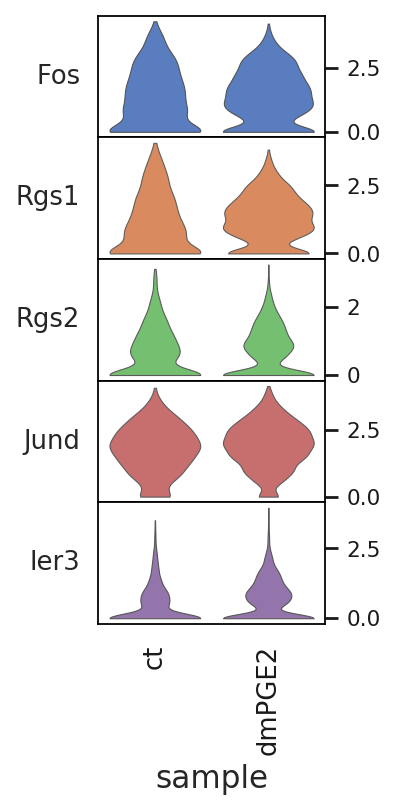

In [51]:
sc.pl.stacked_violin(adata[(adata.obs['sample']=='ct') |
                           (adata.obs['sample']=='dmPGE2') 
                           ],
                         ['Fos', 'Rgs1', 'Rgs2', 'Jund','Ier3'], figsize=(2,5), log=False, swap_axes=True, 
                          groupby='sample', save='_MPP_dmPGE2_directionality.pdf')

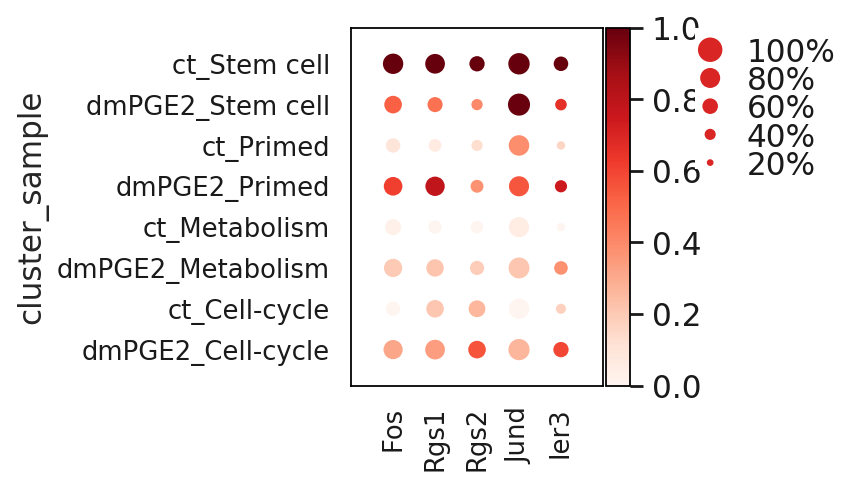

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[2.05, 0, 0.2, 0.5, 0.25])

In [52]:
sc.pl.dotplot(adata[(adata.obs['cluster_sample']=='ct_Cell-cycle') |
                           (adata.obs['cluster_sample']=='ct_Metabolism') |
                           (adata.obs['cluster_sample']=='ct_Primed') |
                           (adata.obs['cluster_sample']=='ct_Stem cell') |
                           (adata.obs['cluster_sample']=='dmPGE2_Primed') |
                           (adata.obs['cluster_sample']=='dmPGE2_Metabolism') |
                           (adata.obs['cluster_sample']=='dmPGE2_Stem cell') |
                           (adata.obs['cluster_sample']=='dmPGE2_Cell-cycle') 
                           ],
                         ['Fos', 'Rgs1', 'Rgs2', 'Jund','Ier3'], figsize=(3,3), log=False, 
                          standard_scale = 'var', groupby='cluster_sample', save='_MPP_dmPGE2_directionality.pdf')

In [53]:
sc.tl.dendrogram(adata, 'cluster_sample', n_pcs=30)

    using 'X_pca' with n_pcs = 30
Storing dendrogram info using `.uns['dendrogram_cluster_sample']`


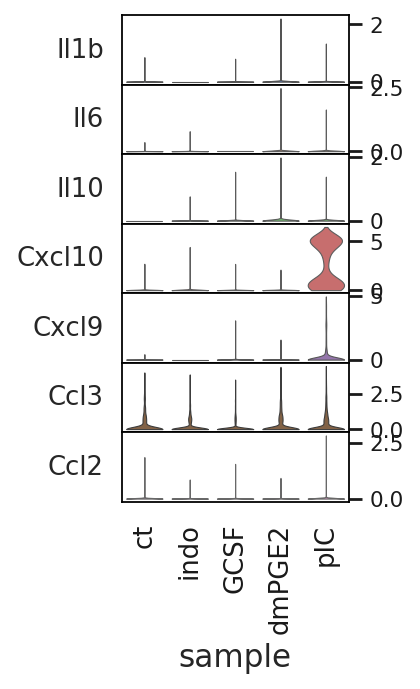

In [54]:
# look at secreted factors

cytokines = ['Il1b', 'Il6', 'Il10', 'Cxcl10', 'Cxcl9', 'Ccl3', 'Ccl2']
sc.pl.stacked_violin(adata[(adata.obs['sample']=='ct') |
                           (adata.obs['sample']=='dmPGE2')|
                           (adata.obs['sample']=='indo') |
                           (adata.obs['sample']=='pIC') |
                           (adata.obs['sample']=='GCSF') 
                           ],
                         cytokines, figsize=(2,4), log=False, swap_axes=True, 
                          groupby='sample')

In [55]:
!pip list

Package                Version            
---------------------- -------------------
alembic                1.3.0              
anndata                0.7.1              
async-generator        1.10               
attrs                  19.3.0             
backcall               0.1.0              
beautifulsoup4         4.8.1              
bleach                 3.1.0              
blinker                1.4                
bokeh                  1.3.4              
cellbrowser            0.7.7              
certifi                2020.4.5.1         
certipy                0.1.3              
cffi                   1.13.2             
chardet                3.0.4              
Click                  7.0                
cloudpickle            1.2.2              
conda                  4.7.12             
conda-package-handling 1.6.0              
cryptography           2.8                
cycler                 0.10.0             
Cython                 0.29.14            
cytoolz    

In [56]:
sc.logging.print_versions()
pd.show_versions()

scanpy==1.4.6 anndata==0.7.1 umap==0.4.1 numpy==1.17.3 scipy==1.3.1 pandas==0.25.3 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.8.0 louvain==0.6.1

INSTALLED VERSIONS
------------------
commit           : None
python           : 3.7.3.final.0
python-bits      : 64
OS               : Linux
OS-release       : 4.19.76-linuxkit
machine          : x86_64
processor        : x86_64
byteorder        : little
LC_ALL           : en_US.UTF-8
LANG             : en_US.UTF-8
LOCALE           : en_US.UTF-8

pandas           : 0.25.3
numpy            : 1.17.3
pytz             : 2019.3
dateutil         : 2.8.1
pip              : 19.3.1
setuptools       : 41.6.0.post20191101
Cython           : 0.29.14
pytest           : None
hypothesis       : None
sphinx           : None
blosc            : None
feather          : None
xlsxwriter       : None
lxml.etree       : None
html5lib         : None
pymysql          : None
psycopg2         : None
jinja2           : 2.10.3
IPython          : 7.9.0
pan